### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import time
import copy
import os

### Select CUDA Device

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
batch_size = 128
learning_rate = 1e-3

### Loading the Data

In [5]:
train_dataset = datasets.ImageFolder(root='../NSSI-Train', transform=transforms)
test_dataset = datasets.ImageFolder(root='../NSSI-Test', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor()
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder('../NSSI-Train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder('../NSSI-Test', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True),
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False)
}

### ResNet-50 Model

In [7]:
net = models.resnet50(pretrained=True)
    
if torch.cuda.is_available():
    net.cuda()
    
for param in net.parameters():
    param.requires_grad = False 
    
net.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [9]:
training_accuracies = []
training_losses = []

def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            training_accuracies.append(epoch_acc)
            training_losses.append(epoch_loss)
    return model

In [10]:
model_trained = train_model(net, criterion, optimizer, num_epochs=8)

Epoch 1/8
----------


/home/anagara8/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/anagara8/.conda/envs/py38/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:793: UserWarning: Truncated File Read
  warnings.warn(str(msg))


train loss: 0.5532, acc: 0.8459
validation loss: 0.4117, acc: 0.9179
Epoch 2/8
----------
train loss: 0.3422, acc: 0.9184
validation loss: 0.2653, acc: 0.9322
Epoch 3/8
----------
train loss: 0.2517, acc: 0.9253
validation loss: 0.2124, acc: 0.9347
Epoch 4/8
----------
train loss: 0.2163, acc: 0.9288
validation loss: 0.1845, acc: 0.9421
Epoch 5/8
----------
train loss: 0.2004, acc: 0.9309
validation loss: 0.1719, acc: 0.9448
Epoch 6/8
----------
train loss: 0.1866, acc: 0.9373
validation loss: 0.1588, acc: 0.9484
Epoch 7/8
----------
train loss: 0.1793, acc: 0.9373
validation loss: 0.1525, acc: 0.9522
Epoch 8/8
----------
train loss: 0.1756, acc: 0.9361
validation loss: 0.1487, acc: 0.9520


### Saving Model Weights and Visualizing

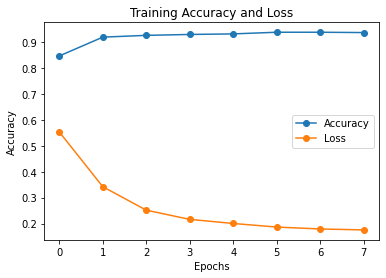

In [31]:
torch.save(model_trained.state_dict(), './models/weights_ceLoss_epoch8.h5')

plt.plot([i.cpu().numpy() for i in training_accuracies[::2]],'-o')
plt.plot(training_losses[::2],'-o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy','Loss'])
plt.title('Training Accuracy and Loss')
plt.show()

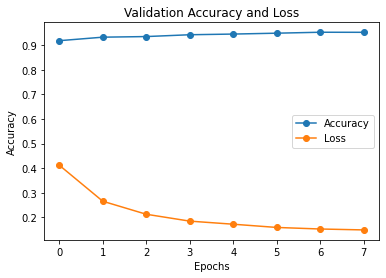

In [32]:
plt.plot([i.cpu().numpy() for i in training_accuracies[1::2]],'-o')
plt.plot(training_losses[1::2],'-o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy','Loss'])
plt.title('Validation Accuracy and Loss')
plt.show()

### Loading saved weights to memory

In [ ]:
net = models.resnet50(pretrained=False).to(device)
net.fc = nn.Sequential(nn.Linear(2048, 128), nn.ReLU(inplace=True), nn.Linear(128, 2)).to(device)
net.load_state_dict(torch.load('./models/weights_ceLoss_epoch8.h5'))